In [1]:
! pip install grad-cam

     |████████████████████████████████| 7.8 MB 4.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38242 sha256=a47b8c98ed9429d46cbbb4020d14bbbffab80608c1a4f5b475c0dbb0e4e9b7bc
  Stored in directory: /home/ubuntu/.cache/pip/wheels/a4/6a/11/fa213a7aaae1a99a800b86bdd1cc95bc9c7d7914b0859663b8
Successfully built grad-cam


In [1]:
import torch
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

%matplotlib inline
torch.__version__

'1.12.0'

In [2]:
def seed_everything(seed):
    # random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
# seed_everything(0)

In [3]:
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        if '_' in item:
            continue
        img = cv2.imread(os.path.join(folder,item),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append([img,target])
    return images

In [4]:
bengin = import_images("./Dataset_BUSI_with_GT/benign/",0)
malignant = import_images("./Dataset_BUSI_with_GT/malignant/",1)
normal = import_images("./Dataset_BUSI_with_GT/normal/",2)

bengin.extend(malignant)
bengin.extend(normal)

full_data = bengin

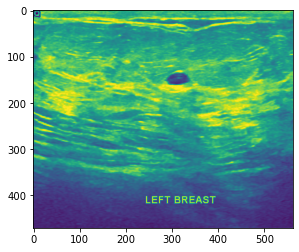

In [5]:
%matplotlib inline

plt.imshow(full_data[0][0])

In [6]:
feature_matrix = []
label = []
for x,y in full_data:
    feature_matrix.append(x)
    label.append(y)

# resized image
X=[]
img_size=128

for x in feature_matrix:
    new_array = cv2.resize(x,(img_size,img_size))
    X.append(new_array / 255.0)
X = np.array(X)
X = X.reshape((X.shape[0], 1, X.shape[1], X.shape[2]))
X = X.astype(np.float32)

label = np.array(label)

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,label)

In [8]:
len(X_train),len(X_test),len(y_train),len(y_test)

(585, 195, 585, 195)

In [9]:
s = int(len(X_train) * 0.8)
X_val = X_train[s:]
X_train = X_train[:s]

s = int(len(y_train) * 0.8)
y_val = y_train[s:]
y_train = y_train[:s]

In [10]:
len(X_train), len(X_val), len(X_test)

(468, 117, 195)

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

train_dataset = TensorDataset(X_train, y_train)

train_dataloader = DataLoader(
            train_dataset,
            batch_size = 8,
            shuffle = True
)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = torch.nn.Linear(8 * 8 * 128, 256, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        self.fc2 = torch.nn.Linear(256, 3, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.layer5(out)
        out = self.fc2(out)
        return out

In [43]:
model = CNN().to(device)

In [44]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [45]:
for epoch in range(50):
    avg_loss = 0
    model.train()
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        avg_loss += loss
        loss.backward()
        optimizer.step()
    

    model.eval()
    with torch.no_grad():
        
        prediction = model(torch.tensor(X_val).cuda())
        vl = criterion(prediction, torch.tensor(y_val).cuda())
        correct_prediction = torch.argmax(prediction, 1) == torch.tensor(y_val).cuda()
        accuracy = correct_prediction.float().mean()
    print(f'[Epoch: {epoch+1:>4}], train_loss = {avg_loss:>.5}, val_loss = {vl:>.5}, val_acc = {accuracy:>.5}')

    # if best_acc < vali_acc:
    #     best_acc = vali_acc
    #     torch.save(model.state_dict(), './model/best_model.pth') #이 디렉토리에 다른 best_model.pth을 저장
    #     print('---------------------Model Saved.---------------------')

[Epoch:    1], train_loss = 58.6, val_loss = 1.0011, val_acc = 0.55556
[Epoch:    2], train_loss = 57.28, val_loss = 1.0011, val_acc = 0.55556
[Epoch:    3], train_loss = 57.909, val_loss = 1.0047, val_acc = 0.55556
[Epoch:    4], train_loss = 57.366, val_loss = 1.0081, val_acc = 0.55556
[Epoch:    5], train_loss = 57.936, val_loss = 1.0075, val_acc = 0.55556
[Epoch:    6], train_loss = 57.471, val_loss = 1.0082, val_acc = 0.55556
[Epoch:    7], train_loss = 57.55, val_loss = 1.0053, val_acc = 0.55556
[Epoch:    8], train_loss = 57.357, val_loss = 1.0044, val_acc = 0.55556
[Epoch:    9], train_loss = 57.721, val_loss = 1.0037, val_acc = 0.55556
[Epoch:   10], train_loss = 57.533, val_loss = 1.0035, val_acc = 0.55556
[Epoch:   11], train_loss = 56.812, val_loss = 1.0005, val_acc = 0.55556
[Epoch:   12], train_loss = 57.164, val_loss = 1.0049, val_acc = 0.55556
[Epoch:   13], train_loss = 56.79, val_loss = 1.0001, val_acc = 0.55556
[Epoch:   14], train_loss = 57.355, val_loss = 1.0023, v

In [42]:
X_test_c = torch.tensor(X_test).cuda()
y_test_c = torch.tensor(y_test).cuda()

with torch.no_grad():
    prediction = model(X_test_c)
    correct_prediction = torch.argmax(prediction, 1) == y_test_c
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.6820513010025024


In [23]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
def get_img_tensor(img_path):
    img = cv2.imread(img_path, 0)
    h, w = img.shape
    print(h, w)
    img = Image.fromarray(img)
    img = torchvision.transforms.Resize((128,128))(img)
    img = torchvision.transforms.ToTensor()(img)
    img = torchvision.transforms.Normalize((0.406), (0.225))(img)
    img = img.unsqueeze(0)
    return img

In [29]:
img_path = "./Dataset_BUSI_with_GT/normal/normal (133).png"

471 560


/home/ubuntu/anaconda3/envs/seunghee_pytorch1.11.0_p37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


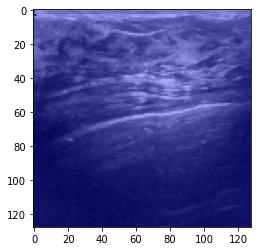

In [30]:
target_layers = [model.layer4[-1]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
img = get_img_tensor(img_path)
image = plt.imread(img_path)
image = cv2.resize(image, (128,128))
pred = int(torch.argmax(torch.nn.Softmax()(model(img.cuda()))).item())
targets = [ClassifierOutputTarget(pred)]
grayscale_cam = cam(input_tensor=img, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)